# Bee detection using a RetinaNet architecture

Implementation based on the following sources:

- https://blog.zenggyu.com/en/post/2018-12-05/retinanet-explained-and-demystified/#fnref11
- https://github.com/yhenon/pytorch-retinanet

## Contents

- [Preparations](#preparations)
- [Configuration](#configuration)
- [Load dataset](#load-dataset)
- [Visualization for images and bounding boxes](#visualize-pairs)
- [RetinaNet](#retinanet)
- [Loading and saving a model](#loading-saving)
- [Training](#training)
- [Evaluation](#evaluation)
- [Backbone optimization](#backbone-optimization)
- [Focal loss function optimization](#focal-loss-optimization)
- [Optimizer Evaluation loop](#optimizer-eval)
- [Inference time benchmark](#inference-benchmark)
- [Test some images](#test-images)

<a id="preparations"></a>

## Preparations

In [1]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install boto3
!pip install scikit-image

import os
import json
import collections
import math
import time
import pathlib

import skimage.transform

import torch
import torch.nn as nn
import torchvision

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

from PIL import Image

from IPython.display import display, clear_output

import boto3

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


<a id="configuration"></a>

## Configuration

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data to use
USE_LOCAL_FILES = True # Whether to fetch the files from IMAGES_FOLDER_PATH and LABELING_FILE_PATH or from the AWS S3 bucket
IMAGES_FOLDER_PATH = "DATA/images/"
IMAGES_FILE_EXTENSION = ".png"
LABELING_FILE_PATH = "DATA/mapping/output.manifest"

# Input resizing settings
MIN_IMAGE_SIDE = 608
MAX_IMAGE_SIDE = 1024

# General training options
VALIDATION_SPLIT = 0.2 # Splitting dataset in both training and validation sets
LEARNING_RATE = 1e-2
EPOCHS = 10

# Focal loss - loss function
ALPHA = 0.25
GAMMA = 2.0

# Feature pyramid network
PYRAMID_LEVELS = [2, 3, 4, 5, 6, 7] # Add or remove the number 2

# Anchor boxes
ANCHOR_SCALES = [2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0), 2]
ANCHOR_RATIOS = [0.5, 1, 2]

# Prediction settings
MIN_SCORE = 0.05
NMS_THRESHOLD = 0.5

# Optimzer SGD
WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9

<a id="load-dataset"></a>

## Load dataset

Either from the AWS S3 bucket or from local files (See constants `IMAGES_FOLDER_PATH`, `LABELING_FILE_PATH` and `USE_LOCAL_FILES` in the configuration section.

In [3]:
class Normalizer(object):
    """
    Normalizer used to normalize the images in our bee dataset.
    """
    
    def __init__(self):
        self.mean = np.array([[[0.485, 0.456, 0.406]]]) # Mean values for RGB
        self.std = np.array([[[0.229, 0.224, 0.225]]]) # Standard deviations for RGB
    
    def __call__(self, sample):
        """
        Normalize the passed sample from the bee dataset.
        """
        
        image, gt_boxes = sample
        
        return ((image.astype(np.float32) / 255.0 - self.mean) / self.std), gt_boxes


class Resizer(object):
    """
    Resize filter that will resize the images and ground truth bounding boxes
    in our bee dataset.
    """

    def __call__(self, sample, min_side=MIN_IMAGE_SIDE, max_side=MAX_IMAGE_SIDE, padding_base=32):
        """
        Resize the passed sample from the bee dataset.
        
        Args:
            sample - sample from the bee dataset
            min_side - minimum side of the image
            max_side - maximum side of the image
            padding_base - value to pad the image to
        """
        
        image, gt_boxes = sample
        height, width, channels = image.shape
        
        # Fetch scale factor to match the input min_side
        smallest_side = min(height, width) # Find the smallest side
        scale_factor = min_side / smallest_side
        
        # Fetch scale factor to match the input max_side
        largest_side = max(height, width)
        if largest_side * scale_factor > max_side:
            scale_factor = max_side / largest_side
        
        # Resize the image
        target_width = int(round(width * scale_factor))
        target_height = int(round(height * scale_factor))
        image = skimage.transform.resize(image, (target_height, target_width))
        
        # Apply padding on the image
        height, width, channels = image.shape
        
        padding_height = padding_base - height % padding_base
        padding_width = padding_base - width % padding_base
        
        padded_image = np.zeros((height + padding_height, width + padding_width, channels), dtype=np.float32)
        padded_image[:height, :width, :] = image.astype(np.float32)
        
        # Resize ground truth bounding boxes as well (:4 because we do not want to scale the class which is the fifth element)
        gt_boxes[:, :4] = gt_boxes[:, :4] * scale_factor
        
        # Permute the image dimensions to match the pytorch expected format (CHANNELS x HEIGHT x WIDTH).
        # Currently the image is in format (HEIGHT x WIDTH x CHANNELS).
        result_image = np.moveaxis(padded_image, 2, 0) # Moving axis with index 2 (currently CHANNELS) to index 0 (currently HEIGHT) -> resulting in (CHANNELS x HEIGHT x WIDTH)
        
        # Convert image and ground truth boxes to PyTorch tensors and return them along with the resulting scale factor
        return torch.from_numpy(result_image), torch.from_numpy(gt_boxes), scale_factor


class BeeDataSet(torch.utils.data.Dataset):

    def __init__(
        self,
        image_folder_path=None, 
        labeling_file_path=None, 
        image_extension=".png",
        image_transform=torchvision.transforms.Compose([Normalizer(), Resizer()])
    ):
        """
        Initializing the Bee dataset.
        * image_folder_path: Path to the folder containing all image files, if not set the S3 bucket is used
        * labeling_file_path: Path to the labeling file, if not set the S3 bucket is used
        * image_extension: Image extension to read from the image_folder_path or the S3 bucket only
        * image_transform: PyTorch dataset transforms used to transform the images
        """
        
        self.image_folder_path = image_folder_path
        self.labeling_file_path = labeling_file_path
        self.image_extension = image_extension
        
        self.image_transform = image_transform
        self.aws_s3 = boto3.client('s3')
        self.data_entrys = self._get_data_entries()


    def __len__(self):
        """
        Get the size of the data set.
        """

        return len(self.data_entrys)


    def __getitem__(self, index):
        """
        Get an item of the dataset by the passed index.
        The pytorch data loader will use this method.
        
        Returns the image and corresponding label.
        """
        data_entry = self.data_entrys[index]
        
        annotationBoxes = data_entry.getAnnotationBoxes()
        rightFormattedAnnotationBoxes = []
        for annotationBox in annotationBoxes:
            rightFormattedAnnotationBoxes.append(np.array([
                annotationBox.getLeft(),
                annotationBox.getTop(),
                (annotationBox.getLeft() + annotationBox.getWidth()),
                (annotationBox.getTop() + annotationBox.getHeight()),
                0 # Class (Always bee)
            ]))
        annotationBoxes = np.array(rightFormattedAnnotationBoxes)
        
        original_image = data_entry.getImage().getImageAsNumpyNdArray()
        
        if self.image_transform is not None:
            transformed_image, annotationBoxes, scale = self.image_transform([original_image, annotationBoxes])
        
        return torchvision.transforms.ToTensor()(original_image), transformed_image, annotationBoxes, data_entry.getImage().imageName, scale

    
    def _get_local_file_names(self):
        return list(file for file in os.listdir(self.image_folder_path) if file.endswith(self.image_extension))

    
    def _get_remote_file_names(self):
        paginator = self.aws_s3.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket='labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb')

        file_names = []
        for page in pages:
            for obj in page['Contents']:
                file_name = obj['Key']

                if file_name.endswith(self.image_extension):
                    file_names.append(file_name)
        
        return file_names

    
    def _get_file_names(self):
        if self.image_folder_path is not None:
            return self._get_local_file_names()
        else:
            return self._get_remote_file_names()


    def _get_local_annotations_as_map(self, labeling_file_path):
        """
        Read the labeling (list of bounding boxes per image)
        from the passed labeling file path.
        """
        
        labeling_map = {}
        with open(labeling_file_path) as labeling_file:
            for line in labeling_file: 
                src = json.loads(line) # Parse JSON line
                
                # Fetch image file name this labeling corresponds to
                image_file_name = src["source-ref"].split("/")[-1]
                labeling_map[image_file_name] = list(src["bee-labeling-2k-batch-01"]["annotations"])
        
        return labeling_map


    def _get_remote_annotations_as_map(self):
        !pip install smart_open
        from smart_open import smart_open
        
        annotationsMap = {}
        
        with smart_open('s3://labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb/bee-labeling-2k-batch-01/manifests/output/output.manifest', 'rb') as s3_source:
            for line in s3_source:
                decodedLine = line.decode('utf8')
                decodedLine = decodedLine.replace('s3://labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb/', '')
                asJson = json.loads(decodedLine)
                #print(asJson)
                beeLabelingBatch = asJson['bee-labeling-2k-batch-01']
                annotationsMap[asJson['source-ref']] = beeLabelingBatch['annotations']

        return annotationsMap

    
    def _get_annotations_as_map(self):
        if self.labeling_file_path is not None:
            return self._get_local_annotations_as_map(self.labeling_file_path)
        else:
            return self._get_remote_annotations_as_map()
        

    def _get_data_entries(self):
        entries = []
        
        file_names = self._get_file_names()
        annotations_map = self._get_annotations_as_map()
        
        for file_name in file_names:
            annotations = annotations_map[file_name]
            annotation_boxes = []
            
            if len(annotations) == 0:
                continue
            
            for annotation in annotations:
                annotation_boxes.append(self.AnnotationBox(annotation))
            
            image = None
            if self.image_folder_path is not None:
                image = Image.open(os.path.join(self.image_folder_path, file_name))
            
            entries.append(self.DataEntry(annotation_boxes, self.Image(imageName=file_name, image=image)))
            
        return entries


    class DataEntry():
        def __init__(self, annotationBoxes, image):
            self.annotationBoxes = annotationBoxes
            self.image = image
        
        def getAnnotationBoxes(self):
            return self.annotationBoxes
        
        def getImage(self):
            return self.image

    class AnnotationBox():
        def __init__(self, annotationDataAsDict):
            self.classId = annotationDataAsDict['class_id']
            self.top = annotationDataAsDict['top']
            self.left = annotationDataAsDict['left']
            self.height = annotationDataAsDict['height']
            self.width = annotationDataAsDict['width']

        def getClassId(self):
            return self.classId

        def getTop(self):
            return self.top

        def getLeft(self):
            return self.left

        def getHeight(self):
            return self.height

        def getWidth(self):
            return self.width
        

    class Image():
        def __init__(self, imageName, image=None):
            self.imageName = imageName
            self.imageAsNumpyNdArray = image
            if self.imageAsNumpyNdArray is not None:
                self.imageAsNumpyNdArray = np.array(self.imageAsNumpyNdArray)
            
            self.s3_bucket = 'labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb'

        def showImage(self):
            import matplotlib.pyplot as plt
            if (self.imageAsNumpyNdArray == None):
                self.__downloadImage__()
            plt.imshow(self.imageAsNumpyNdArray)

        def __downloadImage__(self):
            import io
            with io.BytesIO() as f:
                boto3.client("s3").download_fileobj(Bucket=self.s3_bucket, Key=self.imageName, Fileobj=f)
                f.seek(0)
                
                img_file = Image.open(f)
                
                self.imageAsNumpyNdArray = np.array(img_file)
                
        def getImageAsNumpyNdArray(self):
            if (self.imageAsNumpyNdArray is None):
                self.__downloadImage__()
            return self.imageAsNumpyNdArray

In [4]:
DATASET = BeeDataSet(
    image_folder_path=IMAGES_FOLDER_PATH if USE_LOCAL_FILES else None,
    labeling_file_path=LABELING_FILE_PATH if USE_LOCAL_FILES else None,
    image_extension=IMAGES_FILE_EXTENSION
)

In [5]:
DATASET[0][1].size()

torch.Size([3, 256, 1056])

## Anchor Boxen

In [6]:
def generate_anchors(base_size=16, ratios=None, scales=None):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales w.r.t. a reference window.
    """

    if ratios is None:
        ratios = np.array(ANCHOR_RATIOS)

    if scales is None:
        scales = np.array(ANCHOR_SCALES)

    num_anchors = len(ratios) * len(scales)

    # initialize output anchors
    anchors = np.zeros((num_anchors, 4))

    # scale base_size
    anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T

    # compute areas of anchors
    areas = anchors[:, 2] * anchors[:, 3]

    # correct for ratios
    anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
    anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))

    # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
    anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
    anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

    return anchors

def visualize_anchors_on_image(image, anchors):
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
#     ax.axis("off")
    
    ax.imshow(image.permute(1, 2, 0))
    
    for i in range(0, len(ANCHOR_RATIOS) * len(ANCHOR_SCALES)):
        anchor = anchors[i]

        x = anchor[1].item()
        y = anchor[0].item()
        width = anchor[3] - anchor[1].item()
        height = anchor[2] - anchor[0].item()

        # Normalize to mid of image
        x += 1613/2
        y += 371/2

        rect = patches.Rectangle(
            (x, y), 
            width,
            height,
            linewidth=1,
            edgecolor=(0.2, 0.8, 1.0, 1.0),
            facecolor='none'
        )
        ax.add_patch(rect)

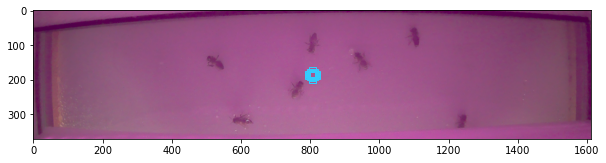

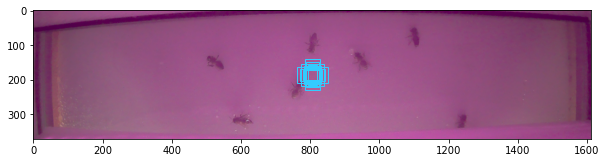

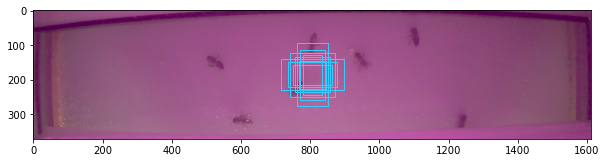

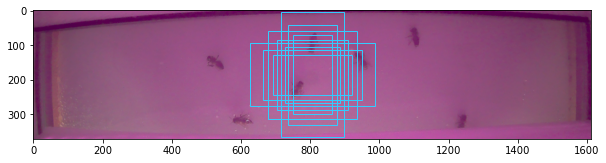

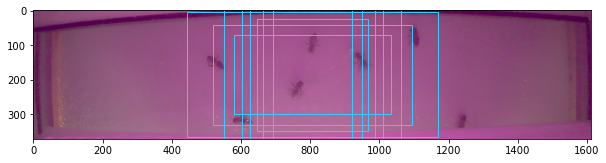

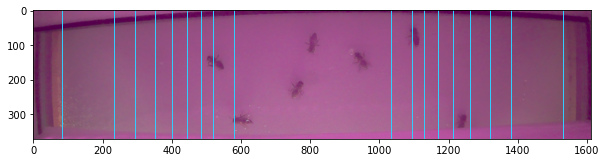

In [7]:
image, _, _, _, _ = DATASET[0]

anchor_width_and_height_dict = {}
for idx, p in enumerate(PYRAMID_LEVELS):
    anchors         = generate_anchors(base_size=[2 ** (x + 2) for x in PYRAMID_LEVELS][idx], ratios=np.array(ANCHOR_RATIOS), scales=np.array(ANCHOR_SCALES))
    anchor_width_and_height_dict[p] = [[anchor[2] - anchor[0],anchor[3] - anchor[1]] for anchor in anchors] # TODO remove this line
    visualize_anchors_on_image(image=image, anchors=anchors)

In [8]:
print("level", "\t", "width", "\t", "height")
for key in anchor_width_and_height_dict:
    level = anchor_width_and_height_dict[key]
    print(key)
    for width_height in level:
        print("\t", round(width_height[0],1), "\t", round(width_height[1], 1))

level 	 width 	 height
2
	 28.5 	 14.3
	 35.9 	 18.0
	 45.3 	 22.6
	 20.2 	 20.2
	 25.4 	 25.4
	 32.0 	 32.0
	 14.3 	 28.5
	 18.0 	 35.9
	 22.6 	 45.3
3
	 57.0 	 28.5
	 71.8 	 35.9
	 90.5 	 45.3
	 40.3 	 40.3
	 50.8 	 50.8
	 64.0 	 64.0
	 28.5 	 57.0
	 35.9 	 71.8
	 45.3 	 90.5
4
	 114.0 	 57.0
	 143.7 	 71.8
	 181.0 	 90.5
	 80.6 	 80.6
	 101.6 	 101.6
	 128.0 	 128.0
	 57.0 	 114.0
	 71.8 	 143.7
	 90.5 	 181.0
5
	 228.1 	 114.0
	 287.4 	 143.7
	 362.0 	 181.0
	 161.3 	 161.3
	 203.2 	 203.2
	 256.0 	 256.0
	 114.0 	 228.1
	 143.7 	 287.4
	 181.0 	 362.0
6
	 456.1 	 228.1
	 574.7 	 287.4
	 724.1 	 362.0
	 322.5 	 322.5
	 406.4 	 406.4
	 512.0 	 512.0
	 228.1 	 456.1
	 287.4 	 574.7
	 362.0 	 724.1
7
	 912.3 	 456.1
	 1149.4 	 574.7
	 1448.2 	 724.1
	 645.1 	 645.1
	 812.7 	 812.7
	 1024.0 	 1024.0
	 456.1 	 912.3
	 574.7 	 1149.4
	 724.1 	 1448.2


<a id="visualize-pairs"></a>

## Visualization for images and bounding boxes

We want to take a look at the images and bounding boxes in our dataset.
Therefore we need a function to do just that.

In [9]:
def visualize_pair(image, scale, predicted_boxes, gt_bboxes=None, captions=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.axis("off")
    
    ax.imshow(image.permute(1, 2, 0))
    
    if gt_bboxes is not None:
        for i in range(len(gt_bboxes)):    
            bbox = gt_bboxes[i]
            
            x = bbox[0] / scale
            y = bbox[1] / scale
            width = (bbox[2] - bbox[0]) / scale
            height = (bbox[3] - bbox[1]) / scale

            rect = patches.Rectangle(
                (x, y),
                width,
                height,
                linewidth=1,
                edgecolor=(1.0, 0.0, 0.0, 0.5),
                facecolor='none'
            )
            ax.add_patch(rect)    
    
    for i in range(len(predicted_boxes)):
        bbox = predicted_boxes[i]
        
        x = bbox[0] / scale
        y = bbox[1] / scale
        width = (bbox[2] - bbox[0]) / scale
        height = (bbox[3] - bbox[1]) / scale
        
        rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=1,
            edgecolor=(0.3, 1.0, 0.8, 0.5),
            facecolor='none'
        )
        ax.add_patch(rect)
        
        if captions is not None:
            caption = captions[i]
            
            ax.annotate(
                caption,
                (x + width / 2, y),
                color='k',
                fontsize=8,
                ha='center',
                va='top'
            )

def visualize_losses(epoch_losses, classification_losses, regression_losses, tick_spacing=1):
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(epoch_losses)), epoch_losses, color = 'red', label = 'Epoch combined Loss')
    ax.plot(np.arange(len(classification_losses)), classification_losses, color = 'blue', label = 'Classication Loss')
    ax.plot(np.arange(len(regression_losses)), regression_losses, color = 'green', label = 'Regression Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_ylim((0,4))
    plt.tight_layout()
    plt.show()

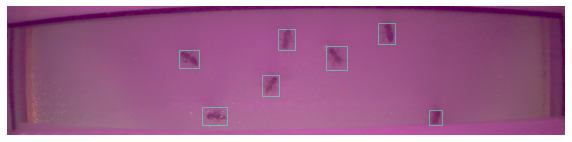

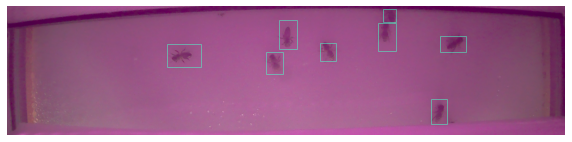

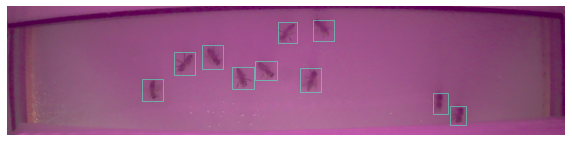

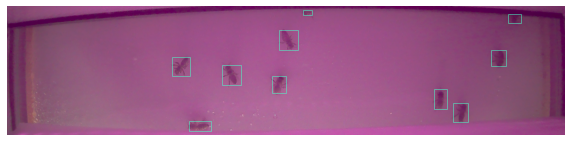

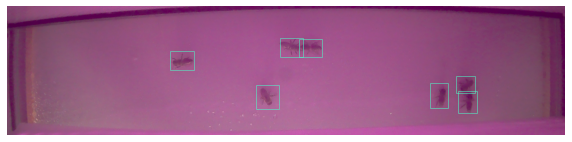

In [10]:
_show_sample_count = 5

for i in range(_show_sample_count):
    image, transformed_image, label, name, scale = DATASET[i]
    visualize_pair(image, scale, label)

<a id="retinanet"></a>

## RetinaNet

Next up we need to define the RetinaNet using PyTorch.
The code is based on the repository at https://github.com/yhenon/pytorch-retinanet

In [11]:
def calc_iou(a, b):
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = torch.min(torch.unsqueeze(a[:, 2], dim=1), b[:, 2]) - torch.max(torch.unsqueeze(a[:, 0], 1), b[:, 0])
    ih = torch.min(torch.unsqueeze(a[:, 3], dim=1), b[:, 3]) - torch.max(torch.unsqueeze(a[:, 1], 1), b[:, 1])

    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)

    ua = torch.unsqueeze((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), dim=1) + area - iw * ih

    ua = torch.clamp(ua, min=1e-8)

    intersection = iw * ih

    IoU = intersection / ua

    return IoU

class FocalLoss(nn.Module):
    
    def __init__(self, alpha=ALPHA, gamma=GAMMA):
        super(FocalLoss, self).__init__()
        
        self.alpha = alpha
        self.gamma = gamma


    def forward(self, classifications, regressions, anchors, annotations):
        alpha = self.alpha
        gamma = self.gamma
        
        batch_size = classifications.shape[0]
        classification_losses = []
        regression_losses = []

        anchor = anchors[0, :, :]

        anchor_widths  = anchor[:, 2] - anchor[:, 0]
        anchor_heights = anchor[:, 3] - anchor[:, 1]
        anchor_ctr_x   = anchor[:, 0] + 0.5 * anchor_widths
        anchor_ctr_y   = anchor[:, 1] + 0.5 * anchor_heights

        for j in range(batch_size):

            classification = classifications[j, :, :]
            regression = regressions[j, :, :]

            bbox_annotation = annotations[j, :, :]
            bbox_annotation = bbox_annotation[bbox_annotation[:, 4] != -1]
            
            classification = torch.clamp(classification, 1e-4, 1.0 - 1e-4)

            if bbox_annotation.shape[0] == 0:
                if torch.cuda.is_available():
                    alpha_factor = torch.ones(classification.shape).cuda() * alpha

                    alpha_factor = 1. - alpha_factor
                    focal_weight = classification
                    focal_weight = alpha_factor * torch.pow(focal_weight, gamma)

                    bce = -(torch.log(1.0 - classification))

                    # cls_loss = focal_weight * torch.pow(bce, gamma)
                    cls_loss = focal_weight * bce
                    classification_losses.append(cls_loss.sum())
                    regression_losses.append(torch.tensor(0).float())
                    
                else:
                    alpha_factor = torch.ones(classification.shape) * alpha

                    alpha_factor = 1. - alpha_factor
                    focal_weight = classification
                    focal_weight = alpha_factor * torch.pow(focal_weight, gamma)

                    bce = -(torch.log(1.0 - classification))

                    # cls_loss = focal_weight * torch.pow(bce, gamma)
                    cls_loss = focal_weight * bce
                    classification_losses.append(cls_loss.sum())
                    regression_losses.append(torch.tensor(0).float())
                    
                continue

            IoU = calc_iou(anchors[0, :, :], bbox_annotation[:, :4]) # num_anchors x num_annotations

            IoU_max, IoU_argmax = torch.max(IoU, dim=1) # num_anchors x 1

            # compute the loss for classification
            targets = torch.ones(classification.shape) * -1

            if torch.cuda.is_available():
                targets = targets.cuda()

            targets[torch.lt(IoU_max, 0.4), :] = 0

            positive_indices = torch.ge(IoU_max, 0.5)

            num_positive_anchors = positive_indices.sum()

            assigned_annotations = bbox_annotation[IoU_argmax, :]

            targets[positive_indices, :] = 0
            targets[positive_indices, assigned_annotations[positive_indices, 4].long()] = 1

            if torch.cuda.is_available():
                alpha_factor = torch.ones(targets.shape).cuda() * alpha
            else:
                alpha_factor = torch.ones(targets.shape) * alpha

            alpha_factor = torch.where(torch.eq(targets, 1.), alpha_factor, 1. - alpha_factor)
            focal_weight = torch.where(torch.eq(targets, 1.), 1. - classification, classification)
            focal_weight = alpha_factor * torch.pow(focal_weight, gamma)

            bce = -(targets * torch.log(classification) + (1.0 - targets) * torch.log(1.0 - classification))

            cls_loss = focal_weight * bce

            if torch.cuda.is_available():
                cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, torch.zeros(cls_loss.shape).cuda())
            else:
                cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, torch.zeros(cls_loss.shape))

            classification_losses.append(cls_loss.sum()/torch.clamp(num_positive_anchors.float(), min=1.0))

            # compute the loss for regression

            if positive_indices.sum() > 0:
                assigned_annotations = assigned_annotations[positive_indices, :]

                anchor_widths_pi = anchor_widths[positive_indices]
                anchor_heights_pi = anchor_heights[positive_indices]
                anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
                anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

                gt_widths  = assigned_annotations[:, 2] - assigned_annotations[:, 0]
                gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
                gt_ctr_x   = assigned_annotations[:, 0] + 0.5 * gt_widths
                gt_ctr_y   = assigned_annotations[:, 1] + 0.5 * gt_heights

                # clip widths to 1
                gt_widths  = torch.clamp(gt_widths, min=1)
                gt_heights = torch.clamp(gt_heights, min=1)

                targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / anchor_widths_pi
                targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / anchor_heights_pi
                targets_dw = torch.log(gt_widths / anchor_widths_pi)
                targets_dh = torch.log(gt_heights / anchor_heights_pi)

                targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh))
                targets = targets.t()

                targets = targets / torch.Tensor([[0.1, 0.1, 0.2, 0.2]]).to(DEVICE)

                negative_indices = 1 + (~positive_indices)

                regression_diff = torch.abs(targets - regression[positive_indices, :])

                regression_loss = torch.where(
                    torch.le(regression_diff, 1.0 / 9.0),
                    0.5 * 9.0 * torch.pow(regression_diff, 2),
                    regression_diff - 0.5 / 9.0
                )
                regression_losses.append(regression_loss.mean())
            else:
                regression_losses.append(torch.tensor(0).float().to(DEVICE))

        return torch.stack(classification_losses).mean(dim=0, keepdim=True), torch.stack(regression_losses).mean(dim=0, keepdim=True)


class Anchors(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, sizes=None, ratios=None, scales=None):
        super(Anchors, self).__init__()
        
        if pyramid_levels is None:
            self.pyramid_levels = PYRAMID_LEVELS
        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]
        if sizes is None:
            self.sizes = [2 ** (x + 2) for x in self.pyramid_levels]
        if ratios is None:
            self.ratios = np.array(ANCHOR_RATIOS)
        if scales is None:
            self.scales = np.array(ANCHOR_SCALES)

    def forward(self, image):
        image_shape = image.shape[2:]
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        # compute anchors over all pyramid levels
        all_anchors = np.zeros((0, 4)).astype(np.float32)
        
        for idx, p in enumerate(self.pyramid_levels):
            anchors         = generate_anchors(base_size=self.sizes[idx], ratios=self.ratios, scales=self.scales)
            shifted_anchors = shift(image_shapes[idx], self.strides[idx], anchors)
            all_anchors     = np.append(all_anchors, shifted_anchors, axis=0)
        
        all_anchors = np.expand_dims(all_anchors, axis=0)

        return torch.from_numpy(all_anchors.astype(np.float32)).to(DEVICE)            
    
# todo hier war generate_anchors vorher

def compute_shape(image_shape, pyramid_levels):
    """Compute shapes based on pyramid levels.
    :param image_shape:
    :param pyramid_levels:
    :return:
    """
    image_shape = np.array(image_shape[:2])
    image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in pyramid_levels]
    return image_shapes


def anchors_for_shape(
    image_shape,
    pyramid_levels=None,
    ratios=None,
    scales=None,
    strides=None,
    sizes=None,
    shapes_callback=None,
):

    image_shapes = compute_shape(image_shape, pyramid_levels)

    # compute anchors over all pyramid levels
    all_anchors = np.zeros((0, 4))
    for idx, p in enumerate(pyramid_levels):
        anchors         = generate_anchors(base_size=sizes[idx], ratios=ratios, scales=scales)
        shifted_anchors = shift(image_shapes[idx], strides[idx], anchors)
        all_anchors     = np.append(all_anchors, shifted_anchors, axis=0)

    return all_anchors


def shift(shape, stride, anchors):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel(),
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    A = anchors.shape[0]
    K = shifts.shape[0]
    all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    all_anchors = all_anchors.reshape((K * A, 4))

    return all_anchors


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class BBoxTransform(nn.Module):

    def __init__(self, mean=None, std=None):
        super(BBoxTransform, self).__init__()
        
        if mean is None:
            self.mean = torch.from_numpy(np.array([0, 0, 0, 0]).astype(np.float32)).to(DEVICE)
        else:
            self.mean = mean
        if std is None:
            self.std = torch.from_numpy(np.array([0.1, 0.1, 0.2, 0.2]).astype(np.float32)).to(DEVICE)
        else:
            self.std = std


    def forward(self, boxes, deltas):
        widths  = boxes[:, :, 2] - boxes[:, :, 0]
        heights = boxes[:, :, 3] - boxes[:, :, 1]
        ctr_x   = boxes[:, :, 0] + 0.5 * widths
        ctr_y   = boxes[:, :, 1] + 0.5 * heights

        dx = deltas[:, :, 0] * self.std[0] + self.mean[0]
        dy = deltas[:, :, 1] * self.std[1] + self.mean[1]
        dw = deltas[:, :, 2] * self.std[2] + self.mean[2]
        dh = deltas[:, :, 3] * self.std[3] + self.mean[3]

        pred_ctr_x = ctr_x + dx * widths
        pred_ctr_y = ctr_y + dy * heights
        pred_w     = torch.exp(dw) * widths
        pred_h     = torch.exp(dh) * heights

        pred_boxes_x1 = pred_ctr_x - 0.5 * pred_w
        pred_boxes_y1 = pred_ctr_y - 0.5 * pred_h
        pred_boxes_x2 = pred_ctr_x + 0.5 * pred_w
        pred_boxes_y2 = pred_ctr_y + 0.5 * pred_h

        pred_boxes = torch.stack([pred_boxes_x1, pred_boxes_y1, pred_boxes_x2, pred_boxes_y2], dim=2)

        return pred_boxes


class ClipBoxes(nn.Module):

    def __init__(self, width=None, height=None):
        super(ClipBoxes, self).__init__()

    def forward(self, boxes, img):
        batch_size, num_channels, height, width = img.shape

        boxes[:, :, 0] = torch.clamp(boxes[:, :, 0], min=0)
        boxes[:, :, 1] = torch.clamp(boxes[:, :, 1], min=0)

        boxes[:, :, 2] = torch.clamp(boxes[:, :, 2], max=width)
        boxes[:, :, 3] = torch.clamp(boxes[:, :, 3], max=height)
      
        return boxes


class PyramidFeatures(nn.Module):
    def __init__(self, C2_size, C3_size, C4_size, C5_size, feature_size=256):
        super(PyramidFeatures, self).__init__()

        # TODO Check global variable PYRAMID_LEVELS and apply accordingly
        
        # upsample C5 to get P5 from the FPN paper
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P5 elementwise to C4
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P4 elementwise to C3
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)
        
        
        if 2 in PYRAMID_LEVELS:
            self.P2_1 = nn.Conv2d(C2_size, feature_size, kernel_size=1, stride=1, padding=0)
            self.P2_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)
            self.P3_upsampled = nn.Upsample(scale_factor=2, mode='nearest')

        # "P6 is obtained via a 3x3 stride-2 conv on C5"
        self.P6 = nn.Conv2d(C5_size, feature_size, kernel_size=3, stride=2, padding=1)

        # "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
        self.P7_1 = nn.ReLU()
        self.P7_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)


    def forward(self, inputs):
        C2, C3, C4, C5 = inputs


        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)

        P3_x = self.P3_1(C3)
        P3_x = P3_x + P4_upsampled_x
        if 2 in PYRAMID_LEVELS:
            P3_upsampled_x = self.P3_upsampled(P3_x)
        P3_x = self.P3_2(P3_x)
        
        P6_x = self.P6(C5)

        P7_x = self.P7_1(P6_x)
        P7_x = self.P7_2(P7_x)
        
        if 2 in PYRAMID_LEVELS:
            P2_x = self.P2_1(C2)
            P2_x = P2_x + P3_upsampled_x
            P2_x = self.P2_2(P2_x)
            return [P2_x, P3_x, P4_x, P5_x, P6_x, P7_x]
        else:
            return [P3_x, P4_x, P5_x, P6_x, P7_x] 


class RegressionModel(nn.Module):

    def __init__(self, num_features_in, num_anchors=9, feature_size=256):
        super(RegressionModel, self).__init__()

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * 4, kernel_size=3, padding=1)


    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)

        # out is B x C x W x H, with C = 4*num_anchors
        out = out.permute(0, 2, 3, 1)

        return out.contiguous().view(out.shape[0], -1, 4)


class ClassificationModel(nn.Module):

    def __init__(self, num_features_in, num_anchors=9, num_classes=80, prior=0.01, feature_size=256):
        super(ClassificationModel, self).__init__()

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()


    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)
        out = self.output_act(out)

        # out is B x C x W x H, with C = n_classes + n_anchors
        out1 = out.permute(0, 2, 3, 1)

        batch_size, width, height, channels = out1.shape

        out2 = out1.view(batch_size, width, height, self.num_anchors, self.num_classes)

        return out2.contiguous().view(x.shape[0], -1, self.num_classes)


class RetinaNet(nn.Module):
    """
    The RetinaNet module.
    """
    
    def __init__(
        self, 
        num_classes, 
        block, 
        layers,
        alpha=ALPHA,
        gamma=GAMMA
    ):
        super(RetinaNet, self).__init__()
        
        self.inplanes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        if block == BasicBlock:
            fpn_sizes = [
                self.layer1[layers[0] - 1].conv2.out_channels,
                self.layer2[layers[1] - 1].conv2.out_channels,
                self.layer3[layers[2] - 1].conv2.out_channels,
                self.layer4[layers[3] - 1].conv2.out_channels
                        ]
        elif block == Bottleneck:
            fpn_sizes = [
                self.layer1[layers[0] - 1].conv3.out_channels,
                self.layer2[layers[1] - 1].conv3.out_channels, 
                self.layer3[layers[2] - 1].conv3.out_channels,
                self.layer4[layers[3] - 1].conv3.out_channels
            ]
        else:
            raise ValueError(f"Block type {block} not understood")

        self.fpn = PyramidFeatures(fpn_sizes[0], fpn_sizes[1], fpn_sizes[2], fpn_sizes[3])

        self.regressionModel = RegressionModel(256)
        self.classificationModel = ClassificationModel(256, num_classes=num_classes)

        self.anchors = Anchors()

        self.regressBoxes = BBoxTransform()

        self.clipBoxes = ClipBoxes()

        self.focalLoss = FocalLoss(alpha=alpha, gamma=gamma)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        prior = 0.01

        self.classificationModel.output.weight.data.fill_(0)
        self.classificationModel.output.bias.data.fill_(-math.log((1.0 - prior) / prior))

        self.regressionModel.output.weight.data.fill_(0)
        self.regressionModel.output.bias.data.fill_(0)

        self.freeze_bn()
        
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def freeze_bn(self):
        """
        Freeze BatchNorm layers.
        """
        
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()


    def forward(self, inputs):
        if self.training:
            img_batch, annotations = inputs
        else:
            img_batch = inputs
            
        x = self.conv1(img_batch)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        features = self.fpn([x1, x2, x3, x4])

        regression = torch.cat([self.regressionModel(feature) for feature in features], dim=1)

        classification = torch.cat([self.classificationModel(feature) for feature in features], dim=1)

        anchors = self.anchors(img_batch)

        if self.training:
            return self.focalLoss(classification, regression, anchors, annotations)
        else:
            transformed_anchors = self.regressBoxes(anchors, regression)
            transformed_anchors = self.clipBoxes(transformed_anchors, img_batch)

            finalResult = [[], [], []]

            finalScores = torch.Tensor([])
            finalAnchorBoxesIndexes = torch.Tensor([]).long()
            finalAnchorBoxesCoordinates = torch.Tensor([])

            finalScores = finalScores.to(DEVICE)
            finalAnchorBoxesIndexes = finalAnchorBoxesIndexes.to(DEVICE)
            finalAnchorBoxesCoordinates = finalAnchorBoxesCoordinates.to(DEVICE)
            
            for i in range(classification.shape[2]):
                scores = torch.squeeze(classification[:, :, i])
                scores_over_thresh = (scores > MIN_SCORE)
                if scores_over_thresh.sum() == 0:
                    # no boxes to NMS, just continue
                    continue

                scores = scores[scores_over_thresh]
                anchorBoxes = torch.squeeze(transformed_anchors)
                anchorBoxes = anchorBoxes[scores_over_thresh]
                anchors_nms_idx = torchvision.ops.nms(anchorBoxes, scores, NMS_THRESHOLD)

                finalResult[0].extend(scores[anchors_nms_idx])
                finalResult[1].extend(torch.tensor([i] * anchors_nms_idx.shape[0]))
                finalResult[2].extend(anchorBoxes[anchors_nms_idx])

                finalScores = torch.cat((finalScores, scores[anchors_nms_idx]))
                finalAnchorBoxesIndexesValue = torch.tensor([i] * anchors_nms_idx.shape[0])
                finalAnchorBoxesIndexesValue = finalAnchorBoxesIndexesValue.to(DEVICE)

                finalAnchorBoxesIndexes = torch.cat((finalAnchorBoxesIndexes, finalAnchorBoxesIndexesValue))
                finalAnchorBoxesCoordinates = torch.cat((finalAnchorBoxesCoordinates, anchorBoxes[anchors_nms_idx]))

            return [finalScores, finalAnchorBoxesIndexes, finalAnchorBoxesCoordinates]

In [12]:
def retinanet_resnet18(num_classes, pretrained=False, alpha=ALPHA, gamma=GAMMA, **kwargs):
    """
    Constructs a RetinaNet model using ResNet-18.
    Args:
        pretrained (bool): If True, returns a model that is pretrained
    """

    model = RetinaNet(num_classes, BasicBlock, [2, 2, 2, 2], alpha=alpha, gamma=gamma, **kwargs)
    
    if pretrained:
        model.load_state_dict(torch.utils.model_zoo.load_url("https://download.pytorch.org/models/resnet18-5c106cde.pth", model_dir='.'), strict=False)
    
    return model


def retinanet_resnet34(num_classes, pretrained=False, alpha=ALPHA, gamma=GAMMA, **kwargs):
    """
    Constructs a RetinaNet model using ResNet-34.
    Args:
        pretrained (bool): If True, returns a model that is pretrained
    """

    model = RetinaNet(num_classes, BasicBlock, [3, 4, 6, 3], alpha=alpha, gamma=gamma, **kwargs)
    
    if pretrained:
        model.load_state_dict(torch.utils.model_zoo.load_url("https://download.pytorch.org/models/resnet34-333f7ec4.pth", model_dir='.'), strict=False)
    
    return model


def retinanet_resnet50(num_classes, pretrained=False, alpha=ALPHA, gamma=GAMMA, **kwargs):
    """
    Constructs a RetinaNet model using ResNet-50.
    Args:
        pretrained (bool): If True, returns a model that is pretrained
    """

    model = RetinaNet(num_classes, Bottleneck, [3, 4, 6, 3], alpha=alpha, gamma=gamma, **kwargs)
    
    if pretrained:
        model.load_state_dict(torch.utils.model_zoo.load_url("https://download.pytorch.org/models/resnet50-19c8e357.pth", model_dir='.'), strict=False)
    
    return model


def retinanet_resnet101(num_classes, pretrained=False, alpha=ALPHA, gamma=GAMMA, **kwargs):
    """
    Constructs a RetinaNet model using ResNet-101.
    Args:
        pretrained (bool): If True, returns a model that is pretrained
    """
    
    model = RetinaNet(num_classes, Bottleneck, [3, 4, 23, 3], alpha=alpha, gamma=gamma, **kwargs)
    
    if pretrained:
        model.load_state_dict(torch.utils.model_zoo.load_url("https://download.pytorch.org/models/resnet101-5d3b4d8f.pth", model_dir='.'), strict=False)
    
    return model


def retinanet_resnet152(num_classes, pretrained=False, alpha=ALPHA, gamma=GAMMA, **kwargs):
    """
    Constructs a RetinaNet model using ResNet-152.
    Args:
        pretrained (bool): If True, returns a model that is pretrained
    """
    
    model = RetinaNet(num_classes, Bottleneck, [3, 8, 36, 3], alpha=alpha, gamma=gamma, **kwargs)
    
    if pretrained:
        model.load_state_dict(torch.utils.model_zoo.load_url("https://download.pytorch.org/models/resnet152-b121ed2d.pth", model_dir='.'), strict=False)
    
    return model

<a id="loading-saving"></a>

## Loading and saving a model

In [13]:
def load_model(name="model"):
    folder_path = os.path.join(".", "DATA", "model", name)
    print(folder_path)
    model = torch.load(os.path.join(folder_path, "model.pt"))
    epoch_losses = np.loadtxt(os.path.join(folder_path, "epoch_losses.csv"), delimiter=",")
    classification_losses = np.loadtxt(os.path.join(folder_path, "classification_losses.csv"), delimiter=",")
    regression_losses = np.loadtxt(os.path.join(folder_path, "regression_losses.csv"), delimiter=",")
    
    print(f"Model and losses '{folder_path}' loaded..")
    
    return model, epoch_losses, classification_losses, regression_losses

def save_model(model, epoch_losses, classification_losses, regression_losses, name="model", path="DATA/model"):
    folder_path = os.path.join(".", path, name)
    os.makedirs(folder_path, exist_ok=True)
    model_file = open(os.path.join(folder_path, "model.pt"), "w")
    torch.save(model, os.path.join(folder_path, "model.pt"))
    
    epoch_file = open(os.path.join(folder_path, "epoch_losses.csv"), "w")
    np.savetxt(epoch_file.name, epoch_losses, delimiter=",")
    
    classification_file = open(os.path.join(folder_path, "classification_losses.csv"), "w")
    np.savetxt(classification_file.name, classification_losses, delimiter=",")
    
    regression_file = open(os.path.join(folder_path, "regression_losses.csv"), "w")
    np.savetxt(regression_file.name, regression_losses, delimiter=",")
    
    print(f"Model and losses saved to '{folder_path}'")

In [19]:
retina_net, epoch_losses, classification_losses, regression_losses = load_model(name="lr_001")

.\DATA\model\lr_001
Model and losses '.\DATA\model\lr_001' loaded..


<a id="training"></a>

## Training

After having the RetinaNet defined, we are able to set up and run the training routine.

In [14]:
# Split dataset in training and test dataset
sizes = np.array([1.0 - VALIDATION_SPLIT, VALIDATION_SPLIT]) * DATASET.__len__()
sizes = sizes.round(0).astype(int)

train_dataset, test_dataset = torch.utils.data.random_split(DATASET, sizes)

In [15]:
def train(
    dataset,
    retina_net,
    optimizer,
    epochs=EPOCHS,
    log=True
):
    """
    Train the model.
    """
    
    epoch_losses = []
    classification_losses = []
    regression_losses = []
    
    # Prepare data loader
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Prepare collections
    loss_hist = collections.deque(maxlen=500)
    
    # Prepare RetinaNet for training
    retina_net = retina_net.to(DEVICE)
    retina_net.training = True
    
    # optimizer = torch.optim.Adam(retina_net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

    retina_net.train()
    retina_net.freeze_bn()
    
    max_batches = len(data_loader)
    
    for epoch in range(epochs):
        retina_net.train()
        retina_net.freeze_bn()
        
        epoch_loss = []
        class_loss = []
        regr_loss = []
        
        for iteration, data in enumerate(data_loader):
            start = time.time()
            
            optimizer.zero_grad()

            img, transformed_img, gt_boxes, image_name, scale = data

            transformed_img = transformed_img.to(DEVICE).float()
            gt_boxes = gt_boxes.to(DEVICE)

            classification_loss, regression_loss = retina_net([transformed_img.float(), gt_boxes.float()])

            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()

            loss = classification_loss + regression_loss

            if bool(loss == 0):
                continue

            loss.backward()

            torch.nn.utils.clip_grad_norm_(retina_net.parameters(), 0.1)

            optimizer.step()

            loss_hist.append(float(loss))

            epoch_loss.append(float(loss))
            
            if not log:
                clear_output(wait=True)    
            display(f"Epoch: {epoch + 1} of {epochs}, Batch {iteration + 1} of {max_batches}, Took {'{:0.2f}'.format((time.time() - start) * 1000)}ms, Mean loss: {'{:0.4f}'.format(np.mean(loss_hist))} (Classification loss: {'{:0.4f}'.format(classification_loss)}, Regression loss: {'{:0.4f}'.format(regression_loss)})")
            class_loss.append(float(classification_loss))
            regr_loss.append(float(regression_loss))
            del classification_loss
            del regression_loss
            
        epoch_losses.append(np.mean(epoch_loss))
        classification_losses.append(np.mean(class_loss))
        regression_losses.append(np.mean(regr_loss))
        
        scheduler.step(np.mean(epoch_loss))
        
    return np.array([
        epoch_losses,
        classification_losses,
        regression_losses
    ])

In [16]:
def get_optimizer(retina_net, use_adam=True, lr=LEARNING_RATE):
    if use_adam:
        return torch.optim.Adam(retina_net.parameters(), lr=lr)
    else:
        params = [p for p in retina_net.parameters() if p.requires_grad]
        return torch.optim.SGD(params, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

In [17]:
##################################
# UNCOMMENT IF YOU WANT TO TRAIN #
##################################

# Create Optimizer from supplier
retina_net = retinanet_resnet34(1, pretrained=True)
retina_net = retina_net.to(DEVICE)

optimizer = get_optimizer(retina_net, use_adam=False, lr=LEARNING_RATE)

epoch_losses, classification_losses, regression_losses = train(train_dataset, retina_net, optimizer, epochs=2, log=False)

'Epoch: 2 of 2, Batch 1599 of 1599, Took 97.00ms, Mean loss: 0.6837 (Classification loss: 0.1351, Regression loss: 0.4811)'

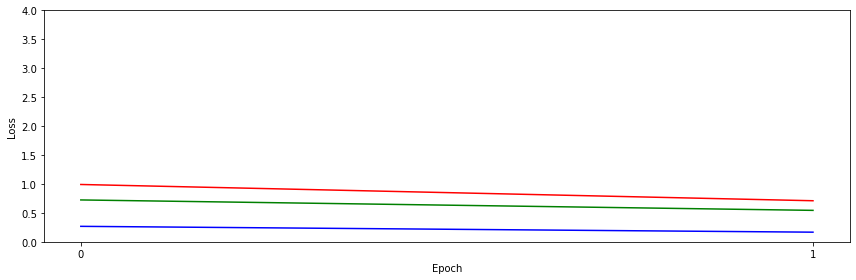

In [18]:
visualize_losses(epoch_losses, classification_losses, regression_losses, tick_spacing=1)

In [ ]:
# save_model(retina_net, epoch_losses, classification_losses, regression_losses, name="bigger_anchor_boxes_random_2")

In [20]:
def test_entry(index, dataset=DATASET, show_gt_boxes=True):
    original_image, transformed_image, label, name, scale = DATASET[index]
    
    transformed_image_size = transformed_image.size()
    transformed_image = transformed_image.expand(1, transformed_image_size[0], transformed_image_size[1], transformed_image_size[2])
    
    transformed_image = transformed_image.to(DEVICE)
    
    retina_net.training = False
    retina_net.eval();
    
    with torch.no_grad():
        scores, classification, transformed_anchors = retina_net(transformed_image)
        
        idxs = np.where(scores.cpu() > 0.5)
        
        predicted_bboxes = []
        captions = []
        for j in range(idxs[0].shape[0]):
            bbox = transformed_anchors[idxs[0][j], :]

            x1 = int(bbox[0])
            y1 = int(bbox[1])
            x2 = int(bbox[2])
            y2 = int(bbox[3])
            
            score = scores[j]
            caption = '{:.3f}'.format(score)
            
            predicted_bboxes.append([x1, y1, x2, y2])
            captions.append(caption)
        
        visualize_pair(original_image, scale, predicted_bboxes, label if show_gt_boxes else None, captions)

## Train Otimization Loop

In [ ]:
# parameter_to_optimize = [1e-3, 1e-4, 1e-5]

# optimizer = get_optimizer()

# for parameter in parameter_to_optimize:
#     train(train_dataset, retina_net, optimizer, learing_rate=parameter)
#     save_model(retina_net, epoch_losses, classification_losses, regression_losses, name=f"learning_rate_{parameter}")

<a id="evaluation"></a>

## Evaluation

In [21]:
from copy import copy

class Evaluation():
    
    def __init__(self):
        self.true_positive_count = 0
        self.false_negative_count = 0
        self.false_positive_count = 0
        self.average_precision_list = []
        self.average_recall_list = []
        
    def __call__(self,scores, predicted_bb, true_bb, iou_threshold):
        
        TP = 0
        FP = 0
        
        true_bb = copy(true_bb).cpu().numpy()
        predicted_bb = copy(predicted_bb)
        predicted_bb_visu = self.filter_pred(scores, predicted_bb)
        predicted_bb = predicted_bb_visu
        true_bb = true_bb[0]

        detect_gt = []
        for pred in predicted_bb:

            if true_bb.shape[0] == 0:
                FP += 1
                TP += 0
                continue

            iou = self.calc_bb_iou(np.expand_dims(pred, axis=0), true_bb)
            match_gt= np.argmax(iou, axis=1)
            max_overlap = iou[0, match_gt]

            if max_overlap >= iou_threshold and match_gt not in detect_gt:
                FP += 0
                TP += 1
                detect_gt.append(match_gt)
            else:
                FP += 1
                TP += 0

        FN = true_bb.shape[0] - len(detect_gt)
        
        eps = np.finfo(np.float64).eps
        
        self.average_precision_list.append(TP/(TP+FP+eps))
        self.average_recall_list.append(TP/(TP+FN+eps))
        
                      
        self.true_positive_count += TP
        self.false_positive_count += FP
        self.false_negative_count += FN
            
        return {'anz_TP': TP, 'anz_FP': FP, 'anz_FN': FN, 'pos_FP': predicted_bb, 'pos_FN': true_bb, 'pred_BB': predicted_bb_visu}
            
    def precision_recall(self):
        try:
            precision = self.true_positive_count / (self.true_positive_count + self.false_positive_count)
            recall = self.true_positive_count / (self.true_positive_count + self.false_negative_count)
            ap = self.calc_ap()
            return {'precision': precision, 'recall': recall, 'Average Precision on BeeDataset': ap}
        except ZeroDivisionError:
            return {'precision':0.0, 'recall': 0.0}
        
    def filter_pred(self, scores, trans_anch):
        
        idxs = np.where(scores.cpu() > 0.5)
        predicted_bboxes = []
        for j in range(idxs[0].shape[0]):
            bbox = trans_anch[idxs[0][j], :]

            x1 = int(bbox[0])
            y1 = int(bbox[1])
            x2 = int(bbox[2])
            y2 = int(bbox[3])
            predicted_bboxes.append([x1, y1, x2, y2])
        return np.asarray(predicted_bboxes)
        
        
        
    def calc_ap(self):
        
        self.average_recall_list.insert(0, 0.0)
        self.average_recall_list.append(1.0)
        mrec = self.average_recall_list[:]
        
        self.average_precision_list.insert(0, 0.0)
        self.average_precision_list.append(0)
        mprec = self.average_precision_list[:]
        
        for i in range(len(mprec)-2, -1, -1):
            mprec[i] = max(mprec[i], mprec[i+1])
            
        index_list =[]
        for i in range(1, len(mrec)):
            if mrec[i] != mrec[i-1]:
                index_list.append(i)
        
        ap = 0
        for i in index_list:                
            ap += ((mrec[i]-mrec[i-1])*mprec[i])  
        
        return ap
    
    def calc_bb_iou(self, bb1, bb2):
        area = (bb2[:, 2] - bb2[:, 0]) * (bb2[:, 3] - bb2[:, 1])

        iw = np.minimum(np.expand_dims(bb1[:, 2], axis=1), bb2[:, 2]) - np.maximum(np.expand_dims(bb1[:, 0], 1), bb2[:, 0])
        ih = np.minimum(np.expand_dims(bb1[:, 3], axis=1), bb2[:, 3]) - np.maximum(np.expand_dims(bb1[:, 1], 1), bb2[:, 1])

        iw = np.maximum(iw, 0)
        ih = np.maximum(ih, 0)

        ua = np.expand_dims((bb1[:, 2] - bb1[:, 0]) * (bb1[:, 3] - bb1[:, 1]), axis=1) + area - iw * ih

        ua = np.maximum(ua, np.finfo(float).eps)

        intersection = iw * ih

        return intersection / ua

In [22]:
def evaluate_model(model, dataset):
    model.to(DEVICE)
    model.training = False
    model.eval()

    evaluate = Evaluation()
    proc_time_sum = 0
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

    max_iteration = len(test_loader)

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            start = time.time()

            img, transformed_img, gt_boxes, image_name, scale = data

            transformed_img = transformed_img.to(DEVICE)

            scores, classification, transformed_anchors = model(transformed_img)

            proc_time = time.time() - start
            proc_time_sum += proc_time

            eval_solution = evaluate(scores, transformed_anchors.detach().cpu(), gt_boxes, iou_threshold = 0.5)

            print('{}/{} | TP:{}, FP:{}, FN:{}'.format(i + 1, max_iteration, eval_solution['anz_TP'], eval_solution['anz_FP'], eval_solution['anz_FN']))

    print('mean processing time for test set: {:.4}msec'.format((proc_time_sum/len(test_loader.dataset))*1000))
    
    return evaluate.precision_recall()

In [23]:
evaluate_model(retina_net, test_dataset)

1/400 | TP:14, FP:2, FN:3
2/400 | TP:24, FP:1, FN:3
3/400 | TP:19, FP:1, FN:0
4/400 | TP:25, FP:0, FN:0
5/400 | TP:16, FP:0, FN:6
6/400 | TP:23, FP:0, FN:3
7/400 | TP:28, FP:1, FN:4
8/400 | TP:18, FP:6, FN:0
9/400 | TP:12, FP:0, FN:3
10/400 | TP:13, FP:0, FN:0
11/400 | TP:31, FP:2, FN:4
12/400 | TP:30, FP:4, FN:1
13/400 | TP:25, FP:3, FN:5
14/400 | TP:26, FP:1, FN:3
15/400 | TP:8, FP:0, FN:0
16/400 | TP:27, FP:3, FN:3
17/400 | TP:16, FP:2, FN:0
18/400 | TP:21, FP:0, FN:1
19/400 | TP:9, FP:0, FN:0
20/400 | TP:30, FP:1, FN:3
21/400 | TP:10, FP:0, FN:0
22/400 | TP:27, FP:3, FN:6
23/400 | TP:9, FP:0, FN:0
24/400 | TP:26, FP:1, FN:5
25/400 | TP:29, FP:0, FN:7
26/400 | TP:34, FP:12, FN:5
27/400 | TP:47, FP:7, FN:15
28/400 | TP:28, FP:4, FN:1
29/400 | TP:26, FP:2, FN:1
30/400 | TP:4, FP:0, FN:0
31/400 | TP:26, FP:0, FN:1
32/400 | TP:21, FP:5, FN:0
33/400 | TP:29, FP:9, FN:13
34/400 | TP:18, FP:1, FN:3
35/400 | TP:16, FP:2, FN:4
36/400 | TP:40, FP:2, FN:5
37/400 | TP:17, FP:0, FN:0
38/400 | TP

298/400 | TP:27, FP:5, FN:5
299/400 | TP:18, FP:7, FN:0
300/400 | TP:24, FP:5, FN:7
301/400 | TP:12, FP:2, FN:1
302/400 | TP:15, FP:0, FN:2
303/400 | TP:41, FP:1, FN:2
304/400 | TP:28, FP:1, FN:4
305/400 | TP:19, FP:0, FN:6
306/400 | TP:33, FP:2, FN:2
307/400 | TP:30, FP:5, FN:4
308/400 | TP:36, FP:3, FN:4
309/400 | TP:10, FP:3, FN:2
310/400 | TP:12, FP:0, FN:0
311/400 | TP:26, FP:3, FN:4
312/400 | TP:28, FP:1, FN:2
313/400 | TP:24, FP:1, FN:5
314/400 | TP:14, FP:0, FN:0
315/400 | TP:24, FP:0, FN:2
316/400 | TP:26, FP:2, FN:2
317/400 | TP:17, FP:0, FN:1
318/400 | TP:36, FP:1, FN:8
319/400 | TP:23, FP:0, FN:1
320/400 | TP:15, FP:1, FN:0
321/400 | TP:22, FP:3, FN:8
322/400 | TP:30, FP:1, FN:4
323/400 | TP:14, FP:2, FN:4
324/400 | TP:29, FP:1, FN:0
325/400 | TP:29, FP:5, FN:0
326/400 | TP:15, FP:2, FN:2
327/400 | TP:29, FP:3, FN:3
328/400 | TP:28, FP:4, FN:4
329/400 | TP:13, FP:1, FN:2
330/400 | TP:24, FP:3, FN:2
331/400 | TP:34, FP:2, FN:8
332/400 | TP:31, FP:2, FN:2
333/400 | TP:33, FP:

{'precision': 0.9004124926340601,
 'recall': 0.889751552795031,
 'Average Precision on BeeDataset': 0.8461538461538461}

<a id="backbone-optimization"></a>

## Backbone optimization

Which backbone is the best for our project?
We attempt to find out by using grid search over all available ResNet backends.

In [ ]:
def optimize_backbone():
    _testing_folder_path = "backbone_testing_results"

    # Defining suppliers for the models to test
    backbone_testing_models = {
        '18-pretrained': lambda: retinanet_resnet18(1, pretrained=True),
        '34-pretrained': lambda: retinanet_resnet34(1, pretrained=True),
        '50-pretrained': lambda: retinanet_resnet50(1, pretrained=True),
        '101-pretrained': lambda: retinanet_resnet101(1, pretrained=True),
        '152-pretrained': lambda: retinanet_resnet152(1, pretrained=True),
        '18': lambda: retinanet_resnet18(1, pretrained=False),
        '34': lambda: retinanet_resnet34(1, pretrained=False),
        '50': lambda: retinanet_resnet50(1, pretrained=False),
        '101': lambda: retinanet_resnet101(1, pretrained=False),
        '152': lambda: retinanet_resnet152(1, pretrained=False),
    }

    for key, supplier in backbone_testing_models.items():
        # Manual seed PyTorch and Numpy
        torch.manual_seed(0)
        np.random.seed(0)

        # Create test result folder for the model
        pathlib.Path(f"{_testing_folder_path}/{key}").mkdir(parents=True, exist_ok=True)

        # Create model from supplier
        model = supplier()

        # Train the model
        optimizer = get_optimizer(model)
        
        start = time.time()
        epoch_losses, classification_losses, regression_losses = train(train_dataset, model, optimizer, epochs=10, log=False)
        took_time_ms = (time.time() - start) * 1000

        # Save the model
        save_model(model, epoch_losses, classification_losses, regression_losses, name=key, path=_testing_folder_path)

        # Save time taken
        with open(f"{_testing_folder_path}/{key}/info.txt", "w") as text_file:
            text_file.write(f"Training took {took_time_ms}ms")

        # Evaluate model
        evaluation_result = evaluate_model(model, test_dataset)

        # Save evaluation result
        with open(f"{_testing_folder_path}/{key}/evaluation_result.json", "w") as text_file:
            text_file.write(json.dumps(evaluation_result))

        # Cleanup
        del model

In [ ]:
# optimize_backbone()

<a id="focal-loss-optimization"></a>

## Focal Loss function optimization

We need to optimize the Alpha and Gamma parameters of the Focal loss function as well.
There are values suggested in the original paper for RetinaNet, which we will try and evaluate the models performance on (See "Focal Loss for Dense Object Detection" by Tsung-Yi Lin et al. 2018, page 6). The default case of the current implementation is marked bold, which is exactly the best performing case from the paper.

| Gamma | Alpha |
| --- | --- |
| 0.0 | 0.75 |
| 0.1 | 0.75 |
| 0.2 | 0.75 |
| 0.5 | 0.50 |
| 1.0 | 0.25 |
| **2.0** | **0.25** |
| 5.0 | 0.25 |

We will only test with the already chosen backbone pretrained ResNet-34.

In [ ]:
def optimize_focal_loss():
    _testing_folder_path = "focal_loss_testing_results"

    # Generating suppliers for the models to test
    gammas = [0.0, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
    alphas = [0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
    models = {}
    for i in range(len(gammas)):
        gamma = gammas[i]
        alpha = alphas[i]
        
        models[f"gamma{gamma}_alpha{alpha}"] = lambda: retinanet_resnet34(1, pretrained=True, alpha=alpha, gamma=gamma)

    for key, supplier in models.items():
        # Manual seed PyTorch and Numpy
        torch.manual_seed(0)
        np.random.seed(0)

        # Create test result folder for the model
        pathlib.Path(f"{_testing_folder_path}/{key}").mkdir(parents=True, exist_ok=True)

        # Create model from supplier
        model = supplier()

        # Train the model
        optimizer = get_optimizer(model)
        
        start = time.time()
        epoch_losses, classification_losses, regression_losses = train(train_dataset, model, optimizer, epochs=10, log=False)
        took_time_ms = (time.time() - start) * 1000

        # Save the model
        save_model(model, epoch_losses, classification_losses, regression_losses, name=key, path=_testing_folder_path)

        # Save time taken
        with open(f"{_testing_folder_path}/{key}/info.txt", "w") as text_file:
            text_file.write(f"Training took {took_time_ms}ms")

        # Evaluate model
        evaluation_result = evaluate_model(model, test_dataset)

        # Save evaluation result
        with open(f"{_testing_folder_path}/{key}/evaluation_result.json", "w") as text_file:
            text_file.write(json.dumps(evaluation_result))

        # Cleanup
        del model

In [ ]:
# optimize_focal_loss()

<a id="optimizer-eval"></a>

## Optimizer Evaluation loop

In [ ]:
def optimizer_loop(use_adam=True):
    _testing_folder_path = "Adam_SGD_optimizer_testing_results"

    # Generating suppliers for the models to test
    parameter_to_optimize = [1e-3, 1e-4, 1e-5]
    optimizer = {}
    
    if use_adam:
        opti = 'Adam'
    else:
        opti = 'SGD'
        
    for i in range(len(parameter_to_optimize)):
        learning_rate = parameter_to_optimize[i]
        
        optimizer[f"optimizer{opti}_learningRate{learning_rate}"] = lambda: get_optimizer(use_adam = use_adam, lr = learning_rate)

    for key, supplier in optimizer.items():
        # Manual seed PyTorch and Numpy
        torch.manual_seed(0)
        np.random.seed(0)

        # Create test result folder for the model
        pathlib.Path(f"{_testing_folder_path}/{key}").mkdir(parents=True, exist_ok=True)
        
        #Create Model
        model = retinanet_resnet34(1, pretrained = True)

        # Create Optimizer from supplier
        optimizer = supplier()

        # Train the model
        start = time.time()
        epoch_losses, classification_losses, regression_losses = train(train_dataset, model, optimizer, epochs=10, log=False)
        took_time_ms = (time.time() - start) * 1000

        # Save the model
        save_model(model, epoch_losses, classification_losses, regression_losses, name=key, path=_testing_folder_path)

        # Save time taken
        with open(f"{_testing_folder_path}/{key}/info.txt", "w") as text_file:
            text_file.write(f"Training took {took_time_ms}ms")

        # Evaluate model
        evaluation_result = evaluate_model(model, test_dataset)

        # Save evaluation result
        with open(f"{_testing_folder_path}/{key}/evaluation_result.json", "w") as text_file:
            text_file.write(json.dumps(evaluation_result))

        # Cleanup
        del model

In [ ]:
# Optimizer Loop for Adam and SGD
#optimizer_loop(use_adam=True)
#optimizer_loop(use_adam=False)

### Learning Rate Optimization Loop

In [ ]:
def optimizer_lr_loop():
    _testing_folder_path = "lr_optimizer_testing_results"

    # Generating suppliers for the models to test
    parameter_to_optimize = [1e-2, 5e-2, 1e-3, 5e-3, 1e-4]
    
    for lr in parameter_to_optimize:
        # Manual seed PyTorch and Numpy
        torch.manual_seed(42)
        np.random.seed(42)

        # Create test result folder for the model
        pathlib.Path(f"{_testing_folder_path}/lr_{lr}").mkdir(parents=True, exist_ok=True)
        
        #Create Model
        model = retinanet_resnet34(1, pretrained=True)
        model = model.to(DEVICE)

        # Create Optimizer from supplier
        optimizer = get_optimizer(model, use_adam=False, lr=lr)
        
        # Train the model
        start = time.time()
        epoch_losses, classification_losses, regression_losses = train(train_dataset, model, optimizer, epochs=10, log=False)
        took_time_ms = (time.time() - start) * 1000

        # Save the model
        save_model(model, epoch_losses, classification_losses, regression_losses, name=f"lr_{lr}", path=_testing_folder_path)

        # Save time taken
        with open(f"{_testing_folder_path}/lr_{lr}/info.txt", "w") as text_file:
            text_file.write(f"Training took {took_time_ms}ms")

        # Evaluate model
        evaluation_result = evaluate_model(model, test_dataset)

        # Save evaluation result
        with open(f"{_testing_folder_path}/lr_{lr}/evaluation_result.json", "w") as text_file:
            text_file.write(json.dumps(evaluation_result))

        # Cleanup
        del model
        del optimizer

In [ ]:
# optimizer_lr_loop()

<a id="inference-benchmark"></a>

## Inference time benchmark

In [24]:
def test_inference_time(model=retina_net, dataset=test_dataset, image_count=400):
    model.training = False
    model.eval();
    
    total_time = 0
    with torch.no_grad():
        for i in range(image_count):
            original_image, transformed_image, label, name, scale = dataset[i]

            transformed_image_size = transformed_image.size()
            transformed_image = transformed_image.expand(1, transformed_image_size[0], transformed_image_size[1], transformed_image_size[2])

            transformed_image = transformed_image.to(DEVICE)
            
            start = time.time()
            model(transformed_image)
            total_time += time.time() - start
            
    print(f"Benchmark took {(total_time * 1000) / image_count}ms on average")

In [25]:
test_inference_time()

Benchmark took 43.96452605724335ms on average


<a id="test-images"></a>

## Test some images

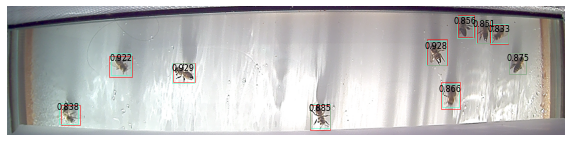

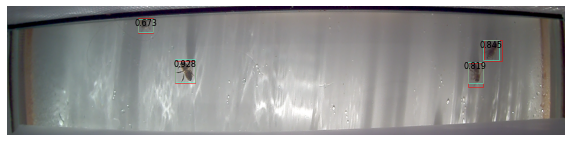

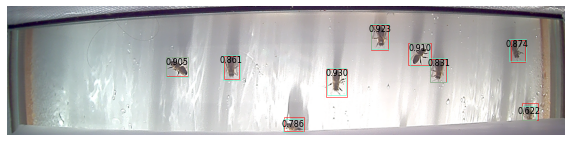

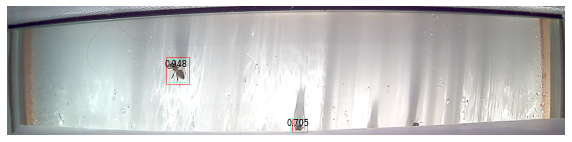

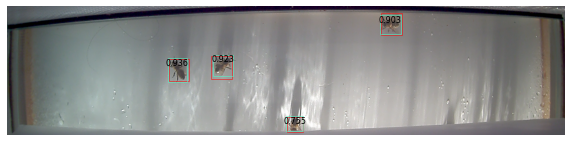

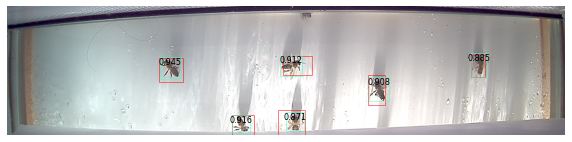

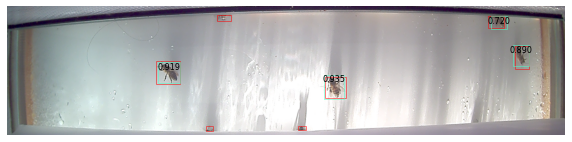

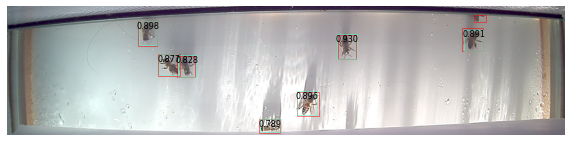

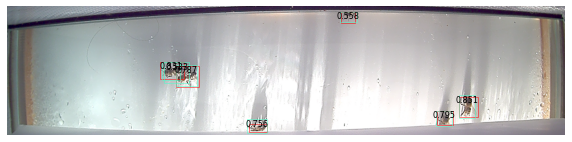

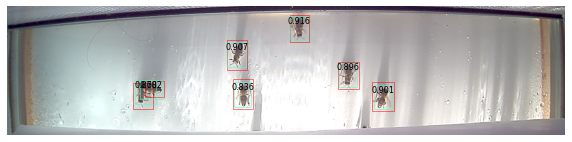

In [26]:
start = 70
count = 10

for i in range(start, start + count):
    # blue boxes represent GT
    # red boxes represent prediction
    test_entry(i)